In [1]:
# nuclio: ignore
import nuclio

In [36]:
%nuclio config kind = "job"
%nuclio config spec.build.baseImage = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.build.baseImage to 'mlrun/ml-models'


In [37]:
%%nuclio cmd -c
pip install scikit-plot git+https://github.com/mlrun/mlutils

In [38]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [39]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model
from cloudpickle import load
from mlutils import eval_class_model

def xgb_test(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    plots_dest: str = "plots",
    model_evaluator = None
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     model artifact to be tested
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param score_method:    for multiclass classification
    :param plots_dest:      dir for test plots
    :param model_evaluator: WIP: specific method to generate eval, passed in as string
                            or available in this folder
    """  
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    model_file, model_obj, _ = get_model(models_path.url, suffix='.pkl')
    model_obj = load(open(model_file, "rb"))

    if not model_evaluator:
        # binary and multiclass
        eval_metrics = eval_class_model(context, xtest, ytest, model_obj)

    # just do this inside log_model?
    model_plots = eval_metrics.pop("plots")
    model_tables = eval_metrics.pop("tables")
    for plot in model_plots:
        context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")
    for tbl in model_tables:
        context.log_artifact(tbl, local_path=f"{plots_dest}/{plot.key}.csv")

    context.log_results(eval_metrics)


In [40]:
# nuclio: end-code

### mlconfig

In [41]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [42]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("xgb_test")

# add metadata (for templates and reuse)
fn.spec.default_handler = "xgb_test"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["ml", "test"]
fn.metadata.labels = {"author": "yjb", "framework": "xgboost"}
fn.export("function.yaml")

[mlrun] 2020-05-13 01:35:20,123 function spec saved to path: function.yaml


In [43]:
if "V3IO_HOME" in list(os.environ):
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # is you set up mlrun using the instructions at https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc('nfsvol', 'nfsvol', '/home/joyan/data'))

In [44]:
task_params = {
    "name" : "tasks xgb test",
    "params": {
        "label_column"  : "labels",
        "plots_dest"    : "plots/xgb_test"}}

[mlrun] 2020-05-13 01:35:20,197 starting run tasks xgb test uid=3ea5d9636d0642a3bc5c4faedc29b267  -> http://mlrun-api:8080
[mlrun] 2020-05-13 01:35:20,450 log artifact calibration curve at /User/artifacts/plots/calibration curve.html, size: 30532, db: Y
[mlrun] 2020-05-13 01:35:20,585 log artifact learning curve - auc at /User/artifacts/plots/learning curve - auc.html, size: 15655, db: Y
[mlrun] 2020-05-13 01:35:20,697 log artifact learning curve - erreur at /User/artifacts/plots/learning curve - erreur.html, size: 15226, db: Y
[mlrun] 2020-05-13 01:35:21,148 log artifact feature-importances at /User/artifacts/plots/xgb_test/feature-importances.html, size: 48490, db: Y
[mlrun] 2020-05-13 01:35:21,200 log artifact confusion-matrix-normalized at /User/artifacts/plots/xgb_test/confusion-matrix-normalized.html, size: 11010, db: Y
[mlrun] 2020-05-13 01:35:21,260 log artifact roc-binary at /User/artifacts/plots/xgb_test/roc-binary.html, size: 16625, db: Y
[mlrun] 2020-05-13 01:35:21,322 log 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...dc29b267,0,May 13 01:35:20,completed,tasks xgb test,v3io_user=adminkind=handlerowner=adminhost=jupyter-545bcf7df-t9vj8,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,test-accuracy=0.9154929577464789test-error=0.08450704225352113rocauc=0.9781217750257997brier_score=0.061994520061779405f1-score=0.927710843373494precision_score=0.9506172839506173recall_score=0.9058823529411765,calibration curvelearning curve - auclearning curve - erreurfeature-importancesconfusion-matrix-normalizedroc-binaryprecision-recall-binaryfeature-importances-tbl


to track results use .show() or .logs() or in CLI: 
!mlrun get run 3ea5d9636d0642a3bc5c4faedc29b267 --project default , !mlrun logs 3ea5d9636d0642a3bc5c4faedc29b267 --project default
[mlrun] 2020-05-13 01:35:21,395 run executed, status=completed


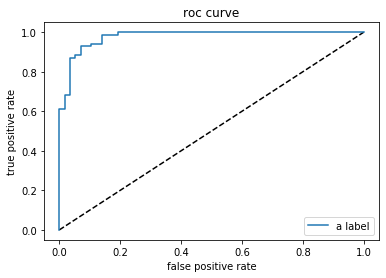

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

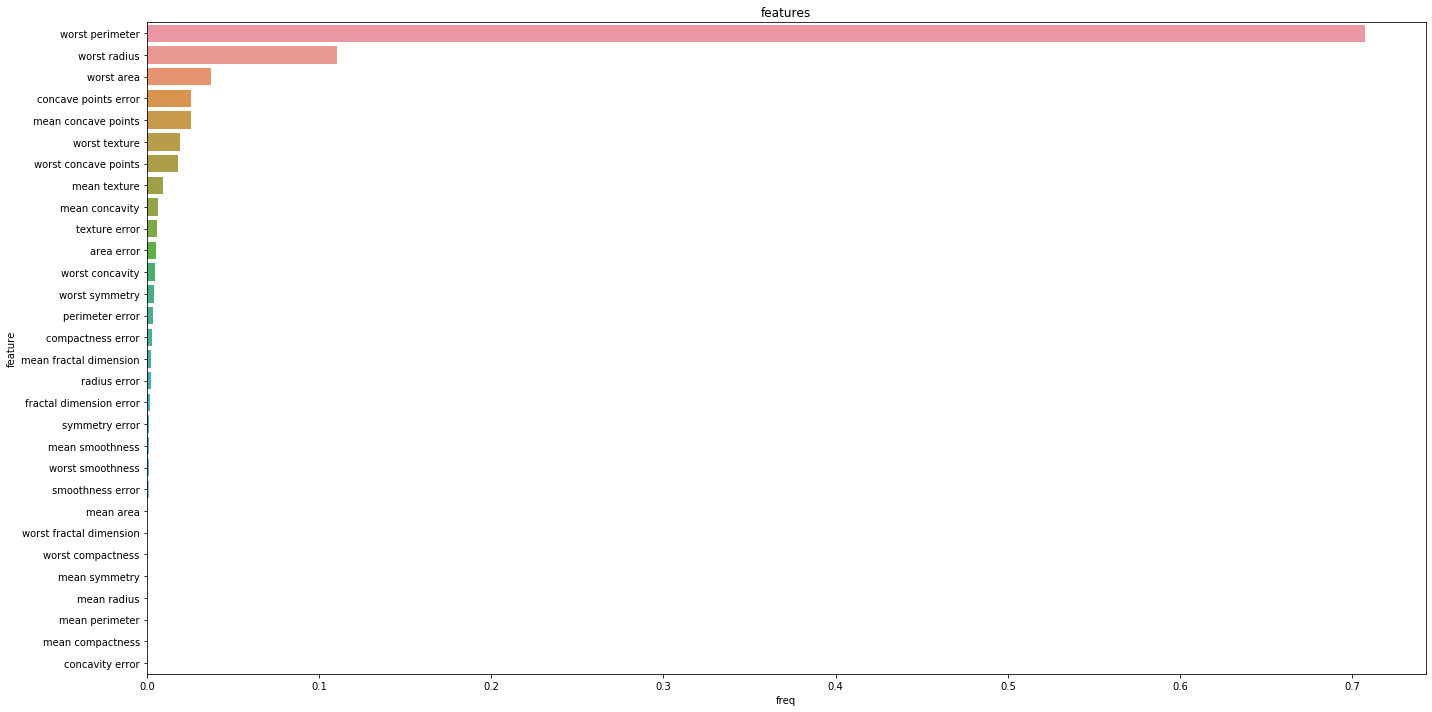

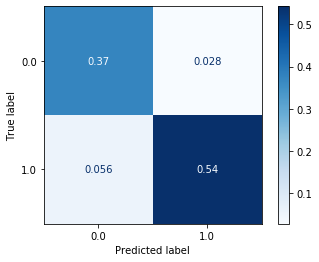

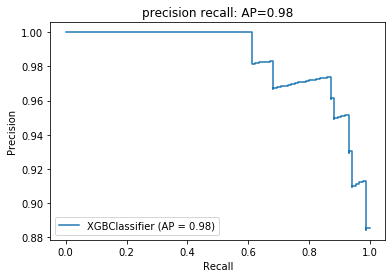

In [45]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=xgb_test,
                inputs={"test_set":"test-set.parquet",
                        "models_path"   : "models"},
                workdir=mlconf.artifact_path)

In [ ]:
fn.deploy(with_mlrun=False)

In [ ]:
run = fn.run(
    NewTask(**task_params),
    inputs={
        "test_set":"test-set.parquet",
        "models_path"   : "models",
        },
    workdir="/User/artifacts")